# INF161: Data Science:  Course Project
### *Predicting Soccer Scores for the Norwegian Women's Soccer Championships (Toppserien)*

> #### by [Sebastian Einar Røkholt](https://www.linkedin.com/in/sebastianrokholt/)
>-------------------------------------------
> *Autumn 2021* 
----------------------------------------------------------------------------

<a id="top"></a> 

<h2> Part 1: Preparations</h2>
    
#### *Notebook Index:*
1. [**Initial Inspection and Handling Missing Values**](#inspection)<br>
2. [**Feature Selection**](#feature-selection) <br>
3. [**Feature Engineering**](#feature-engineering) <br>
    3.1 [*Adding the opponents' matches to the dataset*](#opponent-matches) <br>
    3.2 [*Converting the target feature*](#conversion) <br>
    3.3 [*Preparing the data from the 2020 season*](#preparing-2020-data) <br>
    3.4 [*Visualising the distribution of scores*](#visualising-scores) <br>
    3.5 [*Adding game season and game number in season*](#game-season) <br>
    3.6 [*Adding the average historical score difference*](#ahsd) <br>
    3.7 [*Adding the average number of goals per 90 min last season*](#avg-nr-goals) <br>
    3.8 [*Adding the teams' average age*](#team-avg-age) <br>
    3.9 [*Adding a feature to distinguish top-tier teams*](#top-tier-team) <br>
    3.10 [*One Hot Encoding categorical features*](#ohe) <br>
4. [**Saving the Cleaned Data**](#saving) <br>
<img src="broom.png" alt="A broom" align="left" width="150" height="150"/>

The first part of this machine learning project will consist of data inspection, handling missing values, feature selection and feature engineering. The primary aim of Part 1 is to produce a cleaned dataset to be used for training and evaluating machine learning models. The secondary aim is to engineer features that are useful for predicting the outcome of a soccer match. In order to achieve this, it is important that I visualise the data in a way that allows me to investigate interesting relationships and patterns. 

In [1]:
# Importing notebook dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


# Setting options
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 500)

## <a id="inspection"></a>1) Initial Inspection and Handling Missing Values

In [2]:
# Loading the games dataset
games_2017_df = pd.read_html("Raw Data/2017/games.xls", encoding="UTF-8")[0]
games_2018_df = pd.read_html("Raw Data/2018/games.xls", encoding="UTF-8")[0]
games_2019_df = pd.read_html("Raw Data/2019/games.xls", encoding="UTF-8")[0]

games_2017_df.head()

,Wk,Day,Date,Time,Home,Score,Away,Attendance,Venue,Referee,Match Report,Notes
0,1.0,Mon,2017-04-17,13:00,Medkila,1–1,Sandviken,307.0,Harstad Stadion,Sarah Fatemeh Zangeneh,Match Report,NaN
1,1.0,Mon,2017-04-17,14:00,Avaldsnes,2–1,Vålerenga,346.0,Avaldsnes Idrettssenter,Marit Folstad,Match Report,NaN
2,1.0,Mon,2017-04-17,15:00,Grand Bodø,2–2,Arna-Bjørnar,290.0,Nordlandshallen,Henrikke Holm Nervik,Match Report,NaN
3,1.0,Mon,2017-04-17,15:00,Røa,1–2,Stabæk,348.0,Røabanen,Emilie Dokset,Match Report,NaN
4,1.0,Mon,2017-04-17,15:00,LSK Kvinner,6–1,Klepp,280.0,LSK-hallen,Ingvild Aarland,Match Report,NaN


In [3]:
# Concatenating the games data for 2017, 2018 and 2019 to one dataframe
games_df = pd.concat([games_2017_df, games_2018_df, games_2019_df])
games_df.head()

,Wk,Day,Date,Time,Home,Score,Away,Attendance,Venue,Referee,Match Report,Notes,Round
0,1.0,Mon,2017-04-17,13:00,Medkila,1–1,Sandviken,307.0,Harstad Stadion,Sarah Fatemeh Zangeneh,Match Report,NaN,NaN
1,1.0,Mon,2017-04-17,14:00,Avaldsnes,2–1,Vålerenga,346.0,Avaldsnes Idrettssenter,Marit Folstad,Match Report,NaN,NaN
2,1.0,Mon,2017-04-17,15:00,Grand Bodø,2–2,Arna-Bjørnar,290.0,Nordlandshallen,Henrikke Holm Nervik,Match Report,NaN,NaN
3,1.0,Mon,2017-04-17,15:00,Røa,1–2,Stabæk,348.0,Røabanen,Emilie Dokset,Match Report,NaN,NaN
4,1.0,Mon,2017-04-17,15:00,LSK Kvinner,6–1,Klepp,280.0,LSK-hallen,Ingvild Aarland,Match Report,NaN,NaN


In [4]:
# Initial exploration of the dataset
# Printing the shape
print(f"Shape of games_df: {games_df.shape}")

# Printing the data types for all columns
games_df.dtypes

Shape of games_df: (479, 13)


Wk              float64
Day              object
Date             object
Time             object
Home             object
Score            object
Away             object
Attendance      float64
Venue            object
Referee          object
Match Report     object
Notes            object
Round            object
dtype: object

In [5]:
# Printing the number of missing values for each column
games_df.isna().sum()

Wk               83
Day              81
Date             81
Time             81
Home             81
Score            81
Away             81
Attendance       86
Venue            81
Referee          85
Match Report     81
Notes           477
Round           345
dtype: int64

In [6]:
# Counting rows where all values are missing
games_df_no_nanrows = games_df.dropna(how="all")
print(f"There are {games_df.shape[0]- games_df_no_nanrows.shape[0]} rows where all values are missing.")

There are 81 rows where all values are missing.


In [7]:
# Checking for duplicate rows
print(f"There are {len(games_df[games_df.duplicated(keep=False)])} duplicated rows in the dataset")

There are 81 duplicated rows in the dataset


There are a lot of missing values in the dataset, and some features consist almost entirely of missing values. Luckily there are only a few features which are suitable for prediction. There are also 81 rows that only contain missing values, which make up the bulk of the missing values in the dataset. There are no duplicate rows except for the ones where all values are missing. Removing unwanted features and empty rows, we are left with no missing values in the remaining features.

In [8]:
# Removing columns with >300 NaN values
games_df.drop(columns=["Notes", "Round"], inplace=True)
games_df.head()

# Removing rows with only NaN values
games_df.dropna(axis=0, how="all", inplace=True)

print("Remaining missing values:\n", games_df.isna().sum())

Remaining missing values:
 Wk              2
Day             0
Date            0
Time            0
Home            0
Score           0
Away            0
Attendance      5
Venue           0
Referee         4
Match Report    0
dtype: int64


[*back to top*](#top)
## <a id="feature-selection"></a>2) Feature Selection

I will now look at how the remaining data is represented and which features are suitable for predicting match outcomes. <br>
Since we the "Match Report" feature only contains the string "match report" repeated for all rows, I can safely remove it from the data. Other features are simply unsuitable for predicting soccer scores, at least without supplementing the dataset with more data from external resources. For example, the "Wk", "Day" and "Time" features could help improve predictions if I added weather data for each game. However, I will be sticking to the original dataset, so I will remove these as I deem it unlikely that the day of the week or time of day will consistently impact the performance of some teams more than others. If there is an effect, say that teams play better earlier in the day because they are well rested, it is likely that the effect will be equal for all players on both teams. 

Since a refereees job is to be as objective as possible - though this is sometimes disputed by fans - I will remove the feature containing the name of the referee for each match. Furthermore, though the attendance for each match might slightly affect the performance of the teams playing, I will remove the "Attendance" feature simply because I don't have any data for the expected attendance (tickets sold) for the games I will try to predict for. 

The resulting dataframe should have no missing values, as I am removing the remainding features with NaN values. 

In [9]:
# Removing column 'Match Report'
games_df.drop(columns="Match Report", inplace=True)

# Removing other columns that are unsuitable for predicting scores 
games_df.drop(columns=["Wk", "Day", "Time", "Attendance", "Referee"], inplace=True)

I am left with the 5 features from the original dataset:

In [10]:
# Displaying the first 5 rows
games_df.head()

,Date,Home,Score,Away,Venue
0,2017-04-17,Medkila,1–1,Sandviken,Harstad Stadion
1,2017-04-17,Avaldsnes,2–1,Vålerenga,Avaldsnes Idrettssenter
2,2017-04-17,Grand Bodø,2–2,Arna-Bjørnar,Nordlandshallen
3,2017-04-17,Røa,1–2,Stabæk,Røabanen
4,2017-04-17,LSK Kvinner,6–1,Klepp,LSK-hallen


[*back to top*](#top)
## <a id="feature-engineering"></a>3) Feature Engineering

### <a id="opponent-matches"></a>3.1) Adding the opponents' matches to the dataset

There are still a few things that need to be fixed in terms of how the data is represented. 

A larger issue is that I ultimately want to create a machine learning model that takes as its input the name of a team, the name of it's opponent, and whether the team i playing at home or away. It should then predict the probability of a win, tie or loss. The problem here is that each match is only present in the dataset once, even though there are always two teams playing and therefore two different situations that can be predicted for, i.e: Team A is playing a home game against opponent B at, while the other situation is that Team B is playing an away game against opponent A. 

The outcome of these situations are different, even though they occur simultaneously (and the results are the inverse of each other). To account for this, I am going to rename the features into something more adequate, duplicate the dataframe, switch the teams and the scores so that each match is represented twice and then append the second dataframe to the end of the first. I will then resort the new dataframe ascending by date. 

In [11]:
# Converting all venue locations to "Home"
games_df["Venue"] = "Home"

# Renaming dataframe to reflect that it only contains data about the home team
home_games_df = games_df

# Renaming feature "Home" to "Team"
home_games_df.rename(columns={"Home": "Team", "Away":"Opponent"}, inplace=True)

home_games_df.head()

,Date,Team,Score,Opponent,Venue
0,2017-04-17,Medkila,1–1,Sandviken,Home
1,2017-04-17,Avaldsnes,2–1,Vålerenga,Home
2,2017-04-17,Grand Bodø,2–2,Arna-Bjørnar,Home
3,2017-04-17,Røa,1–2,Stabæk,Home
4,2017-04-17,LSK Kvinner,6–1,Klepp,Home


I will now continue by extending the games dataframe with the opposite configuration of teams and opponents so that every match is represented twice.

In [12]:
# Creating a new df with all of the away games
# Copying the df with the home games
away_games_df = home_games_df.copy(deep=True)

# All of these matches are away games
away_games_df["Venue"] = "Away"

# Renaming so that the home team becomes the opposing team and vice versa
away_games_df.rename(columns={"Team": "Opponent", "Opponent":"Team"}, inplace=True)

# Reversing the score
away_games_df["Score"] = away_games_df["Score"].apply(lambda x: str(x)[::-1])

# Reordering columns
away_games_df = away_games_df[["Date", "Team", "Opponent", "Venue", "Score"]]

# Displaying the new dataframe with only the away games
display(away_games_df.head())

,Date,Team,Opponent,Venue,Score
0,2017-04-17,Sandviken,Medkila,Away,1–1
1,2017-04-17,Vålerenga,Avaldsnes,Away,1–2
2,2017-04-17,Arna-Bjørnar,Grand Bodø,Away,2–2
3,2017-04-17,Stabæk,Røa,Away,2–1
4,2017-04-17,Klepp,LSK Kvinner,Away,1–6


In [13]:
# Appending the away games dataframe to the home games dataframe
games_df = home_games_df.append(away_games_df, ignore_index=True)

# Sorting games by dates, with most recent games at the top
games_df.sort_values(by="Date", axis=0, inplace=True)

# Resetting the index
games_df.reset_index(drop=True, inplace=True)

games_df.head(10)

,Date,Team,Score,Opponent,Venue
0,2017-04-17,Medkila,1–1,Sandviken,Home
1,2017-04-17,Arna-Bjørnar,2–2,Grand Bodø,Away
2,2017-04-17,Stabæk,2–1,Røa,Away
3,2017-04-17,Klepp,1–6,LSK Kvinner,Away
4,2017-04-17,Kolbotn,2–3,Trondheims-Ørn,Away
5,2017-04-17,Vålerenga,1–2,Avaldsnes,Away
6,2017-04-17,Sandviken,1–1,Medkila,Away
7,2017-04-17,Trondheims-Ørn,3–2,Kolbotn,Home
8,2017-04-17,LSK Kvinner,6–1,Klepp,Home
9,2017-04-17,Røa,1–2,Stabæk,Home


Finally, the target variable "Score" is represented as a string object. It needs to be split into two different dependent variables and converted to numerical values. 

### <a id="conversion"></a>3.2) Converting the target feature

In [14]:
# Representing target feature ("Score") as two dependent features suitable for multioutput regression
games_df["y1: Team Score"] = games_df["Score"].apply(lambda x: int(x[0]))  # should be a regex, in case there are 10 goals or more! fix later
games_df["y2: Opponent Score"] = games_df["Score"].apply(lambda x: int(x[-1]))
games_df.drop(["Score"], axis=1, inplace=True)
games_df.head()

,Date,Team,Opponent,Venue,y1: Team Score,y2: Opponent Score
0,2017-04-17,Medkila,Sandviken,Home,1,1
1,2017-04-17,Arna-Bjørnar,Grand Bodø,Away,2,2
2,2017-04-17,Stabæk,Røa,Away,2,1
3,2017-04-17,Klepp,LSK Kvinner,Away,1,6
4,2017-04-17,Kolbotn,Trondheims-Ørn,Away,2,3


### <a id="preparing-2020-data"></a>3.3) Preparing the 2020 games data

The test data needs to be on the same format as above.

In [15]:
games_2020_df = pd.read_csv("Raw Data/2020/test.csv", encoding="UTF-8")
display(games_2020_df.head())

print(games_2020_df.dtypes)

,ID,Date,Season,Team,Opponent,Venue
0,0,2020-08-02,2020,Trondheims-Ørn,Klepp,Home
1,1,2020-07-10,2020,Røa,Vålerenga,Away
2,2,2020-08-30,2020,Trondheims-Ørn,Arna-Bjørnar,Home
3,3,2020-08-26,2020,Vålerenga,Lyn,Home
4,4,2020-09-12,2020,Arna-Bjørnar,Kolbotn,Home


ID           int64
Date        object
Season       int64
Team        object
Opponent    object
Venue       object
dtype: object


In [16]:
# Remove feature "ID" as it is equal to the index, and can be reattached later
game_ids = games_2020_df.ID
games_2020_df = games_2020_df.drop(labels="ID", axis=1)

# Converting Date column from string to datetime
games_2020_df["Date"] = pd.to_datetime(games_2020_df["Date"], yearfirst=True)

# Ensure that each game occurs twice in the dataset, 
# once from the perspective of the home team and once for away
# NB! 2020 data must still be unsorted so that we can re-attach ID's later
sorted_games_2020_df = games_2020_df.sort_values(by="Date", axis=0, inplace=False)
sorted_games_2020_df.head(10)

,Date,Season,Team,Opponent,Venue
153,2020-07-03,2020,LSK Kvinner,Trondheims-Ørn,Away
172,2020-07-03,2020,Trondheims-Ørn,LSK Kvinner,Home
164,2020-07-04,2020,Sandviken,Vålerenga,Home
136,2020-07-04,2020,Røa,Arna-Bjørnar,Home
177,2020-07-04,2020,Avaldsnes,Lyn,Home
130,2020-07-04,2020,Lyn,Avaldsnes,Away
119,2020-07-04,2020,Vålerenga,Sandviken,Away
182,2020-07-04,2020,Arna-Bjørnar,Røa,Away
132,2020-07-05,2020,Klepp,Kolbotn,Home
161,2020-07-05,2020,Kolbotn,Klepp,Away


In [17]:
# Concatenate the 2020 data to the games data
games_df = pd.concat([games_df, games_2020_df], axis=0)
display(games_df.tail(10))

,Date,Team,Opponent,Venue,y1: Team Score,y2: Opponent Score,Season
174,2020-08-16 00:00:00,Kolbotn,Sandviken,Home,NaN,NaN,2020.0
175,2020-12-06 00:00:00,Avaldsnes,Sandviken,Away,NaN,NaN,2020.0
176,2020-10-03 00:00:00,Arna-Bjørnar,LSK Kvinner,Home,NaN,NaN,2020.0
177,2020-07-04 00:00:00,Avaldsnes,Lyn,Home,NaN,NaN,2020.0
178,2020-08-26 00:00:00,Arna-Bjørnar,Sandviken,Home,NaN,NaN,2020.0
179,2020-09-27 00:00:00,Arna-Bjørnar,Sandviken,Away,NaN,NaN,2020.0
180,2020-07-17 00:00:00,Røa,LSK Kvinner,Home,NaN,NaN,2020.0
181,2020-11-07 00:00:00,Kolbotn,LSK Kvinner,Home,NaN,NaN,2020.0
182,2020-07-04 00:00:00,Arna-Bjørnar,Røa,Away,NaN,NaN,2020.0
183,2020-09-12 00:00:00,Sandviken,Lyn,Away,NaN,NaN,2020.0


In [18]:
# Ensuring that Date feature is encoded with Datetime dtype for all rows
games_df["Date"] = pd.to_datetime(games_df["Date"], yearfirst=True)

[*back to top*](#top)
### <a id="visualising-scores"></a>3.4) Visualising the distribution of scores

Before I proceed with the feature engineering, I want to explore some of the statistical properties of the exisiting features. I will start by visualising the distribution of the target variable, which will be the most important feature for training the machine learning models. 

In [19]:
# Separating the 2020 data from the games dataset so that it isn't present in the visualisation
# I want to look at the test data as little as possible
games_2020_df = games_df.loc[games_df["Season"] == 2020].drop(columns=["y1: Team Score", "y2: Opponent Score"])
games_df = games_df.loc[games_df["Season"] != 2020]

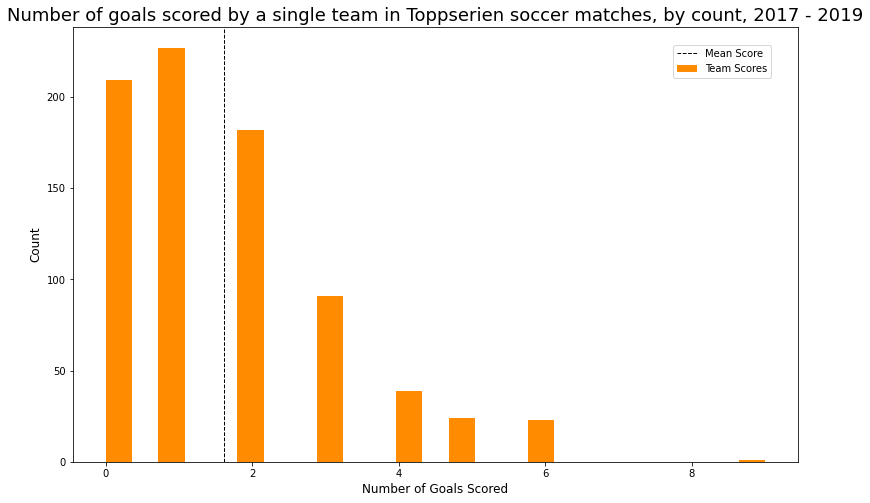

The mean number of goals is 1.6168341708542713


In [20]:
# Visualising the distribution of scores
fig, ax = plt.subplots()
n, bins, patches = ax.hist(games_df["y1: Team Score"], label='Team Scores',
                            stacked=False, color='darkorange', bins=25)

# Adding a vertical line to distinguish the mean value
ax.axvline(games_df["y1: Team Score"].mean(), color='k', linestyle='dashed', linewidth=1, label="Mean Score")
ax.set_ylabel('Count', size=12)
ax.set_xlabel('Number of Goals Scored', size=12)
ax.set_title('Number of goals scored by a single team in Toppserien soccer matches, by count, 2017 - 2019', size=18)
plt.legend(bbox_to_anchor=(0.97, 0.97))

# Setting the plot size
fig.set_figheight(8)
fig.set_figwidth(13)

# Displaying the plot
plt.show()

print(f"The mean number of goals is {games_df['y1: Team Score'].mean()}")

As expected, we can see that most teams score between 0 and 2 goals in a single match. There are, however, a surprising amount of outliers. We see that many teams have scored between 4 and 6 goals, and there is even a team that managed to score 9 (!) goals in a single match. This has some important implications for how I am going to scale the data in the next part of the project.

What's interesting to investigate further is whether the number of goals scored is related to whether the teams are playing a home game or not. I expect that teams generally perform slightly better on their home venue, since they'll have the extra morale from having more supporters cheering them on. Additionally, a better performance might simply be the cause of having to travel less to get to the match venue, and thus having more time to rest before the game. To determine whether there is any correlation between these two variables, I will visualise the same plot but with the scores aggregated by team and venue.

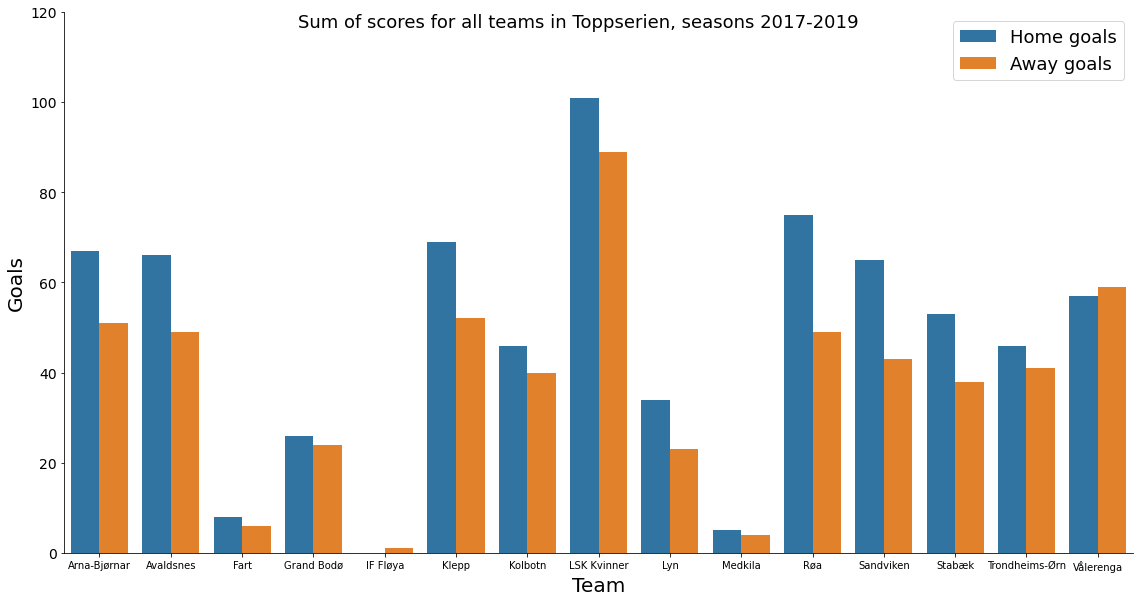

In [21]:
# Visualising the number of goals scored home and away 
# for each team over the course of the 2017, 2018 and 2019 seasons

# Calculating the aggregated sum of goals for each team, for home and away.
# Retrieving all matches played at home and calculate total goals for each team
home_matches = games_df.loc[games_df["Venue"] == "Home"]
home_team_goals = home_matches.groupby("Team")["y1: Team Score"].sum()

# Retrieving all matches played away and calculate total goals for each team
away_matches = games_df.loc[games_df["Venue"] == "Away"]
away_team_goals = away_matches.groupby("Team")["y1: Team Score"].sum()

# Concatenating the results
team_goals = pd.concat([home_team_goals, away_team_goals], axis=1)
team_goals.columns.values[[0, 1]] = ['Home goals', 'Away goals']
team_goals = team_goals.reset_index()

# Melting the results so that each team appears on two rows, once for home and once for away, with goals as value
team_goals_melted = pd.melt(team_goals, id_vars="Team", var_name="Venue", value_name="Goals")

# Plotting the results
g = sns.catplot(x='Team', y='Goals', hue='Venue', data=team_goals_melted, 
            kind='bar', height=8.27, aspect=19/10, legend=False)
g.set_ylabels("Goals", size=20)
g.set_xlabels("Team", size=20)
g.set_yticklabels(size=14)
g.fig.suptitle("Sum of scores for all teams in Toppserien, seasons 2017-2019", size=18)
plt.legend(loc='upper right', fontsize=18)
plt.show()

The plot clearly shows that playing at home is a significant advantage. There are only two teams that haven't scored more goals at home than away, and one of them (*IF Fløya*) is only present in a few samples in the training data. We can also see that the team *LSK Kvinner* has been dominating the championships for the last few years, followed by a handful of other teams. I therefore think that a dummy variable indicating whether the team (or opponent) finished in the top 5 in last year's season might be a very good indicator for how many goals each team is going to score.

### <a id="game-season"></a>3.5) Adding game season and game number in season

I will now derive some new, simple features from the games data while also adding some of the features from the team and tables datasets. I hope that these features might provide what is needed for a solid baseline for predicting the outcome of the 2020 season. More advanced feature engineering will likely occur in the modelling stage. 

Firstly, I would like to denote which game in the season the teams are playing. Since the Toppserien championship consists of 264 games every season such that all 12 team plays against every other team both home and away, I believe that less experienced teams tend to experience more "fatigue" over the course of the season than the more experienced ones. Some teams are also better than others at avoiding injuries, as well as penalty cards. Teams that have a high number of penalty cards may be likely to experience matches later in the season where one or more of their important players aren't allowed on the field, perhaps because they recieved one too many yellow cards over the past few games. In this way, "aggressive" teams - and teams that don't take proper care of their players - might perform progressively worse over the course of the season. 

In [22]:
# Re-joining the games data
games_df = pd.concat([games_df, games_2020_df], axis=0)

In [23]:
# Creating a new feature with only the year of the championship season
games_df["Season"] = games_df["Date"].dt.year

# Creating a new feature with the count of games the team has played, inclusive of current game
teams = set(games_df["Team"].values)
games_played = {team: 0 for team in teams}
current_season = "2017"

# Looping over the dataframe, calculating # of matches played and inserting it to new 'Game # in season' feature
for index, row in games_df.iterrows(): 
    if row["Season"] != current_season:
        current_season = row["Season"]
        games_played = dict.fromkeys(games_played, 0)  # resetting the game count
    games_played[row["Team"]] += 1
    games_df.loc[[index], ["Game # in season"]] = games_played[row["Team"]]

# Displaying the result
display(games_df.head())
display(games_df.tail())

,Date,Team,Opponent,Venue,y1: Team Score,y2: Opponent Score,Season,Game # in season
0,2017-04-17,Medkila,Sandviken,Home,1.0,1.0,2017,1.0
1,2017-04-17,Arna-Bjørnar,Grand Bodø,Away,2.0,2.0,2017,1.0
2,2017-04-17,Stabæk,Røa,Away,2.0,1.0,2017,2.0
3,2017-04-17,Klepp,LSK Kvinner,Away,1.0,6.0,2017,1.0
4,2017-04-17,Kolbotn,Trondheims-Ørn,Away,2.0,3.0,2017,1.0


,Date,Team,Opponent,Venue,y1: Team Score,y2: Opponent Score,Season,Game # in season
179,2020-09-27,Arna-Bjørnar,Sandviken,Away,NaN,NaN,2020,17.0
180,2020-07-17,Røa,LSK Kvinner,Home,NaN,NaN,2020,18.0
181,2020-11-07,Kolbotn,LSK Kvinner,Home,NaN,NaN,2020,20.0
182,2020-07-04,Arna-Bjørnar,Røa,Away,NaN,NaN,2020,18.0
183,2020-09-12,Sandviken,Lyn,Away,NaN,NaN,2020,18.0


### <a id="ahsd"></a>3.6) Adding the average historical score difference

Another interesting feature I would like to calculate is the average historical score difference (let's call it AHSD) between the two teams playing each other. If Stabæk tends to beat Røa by a significant lead every time they play against each other, the historical goal difference should be represented explicitly as a new variable. I would like to experiment more with this metric later, perhaps by using a weighted moving average so that more recent games are weighted more. 

In [24]:
# Calculating the average historical score differance (AHSD) between the two teams playing
score_diffs = {playing_team: {team : [0, 0] for team in teams if team != playing_team} for playing_team in teams}

for index, row in games_df.iterrows():
    # Insert the value for the AHSD
    try:
        ahsd_team_vs_opponent = score_diffs[row['Team']][row['Opponent']][0] / score_diffs[row['Team']][row['Opponent']][1]
        games_df.loc[[index], ["Avg. Historical Score Diff"]] = ahsd_team_vs_opponent
    except ZeroDivisionError:
        # This error implicates that the two teams have never played against each other before
        games_df.loc[[index], ["Avg. Historical Score Diff"]] = 0
    
    # update the AHSD after the current game, unless we are calculating AHSD for games in 2020
    if (not pd.isnull(row["y1: Team Score"])) and (not pd.isnull(row["y2: Opponent Score"])):
        score_diffs[row["Team"]][row["Opponent"]][0] += (row["y1: Team Score"] - row["y2: Opponent Score"])

    # update count of how many times the team has played against the opponent so far
    score_diffs[row["Team"]][row["Opponent"]][1] += 1
    
    
# Reordering the columns so that the predictor variable appears at the end
games_df = games_df[["Season", "Team", "Opponent", "Venue", "Game # in season", "Avg. Historical Score Diff", "Date",  "y1: Team Score", "y2: Opponent Score"]]

display(games_df.tail())

,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,y1: Team Score,y2: Opponent Score
179,2020,Arna-Bjørnar,Sandviken,Away,17.0,-0.571429,2020-09-27,NaN,NaN
180,2020,Røa,LSK Kvinner,Home,18.0,-2.000000,2020-07-17,NaN,NaN
181,2020,Kolbotn,LSK Kvinner,Home,20.0,-1.714286,2020-11-07,NaN,NaN
182,2020,Arna-Bjørnar,Røa,Away,18.0,-0.571429,2020-07-04,NaN,NaN
183,2020,Sandviken,Lyn,Away,18.0,1.800000,2020-09-12,NaN,NaN


### <a id="avg-nr-goals"></a>3.7) Adding the average number of goals per 90 min last season

Next, I will load the teams data and retrieve the avg. number of goals the team scored the previous season per 90 min. This value will be inserted into the games dataframe, along with the same metric for the opposing teams. The reason I am basing this metric on the previous season is that I won't be able to calculate a moving average for the 2020 season since the model will predict the outcome of all games in the season at the same time. The model will only have access to the moving average for the 2019 season, and since ~4 months pass between the 2019 and 2020 seasons any "streaks" or other indicators of a team's current "form" will be rather useless. The avg. number of goals scored should however indicate whether a team is aggressive or defensive, and along with features for received goals the model should be able to predict the end results for games with high- and low-scoring teams more accurately.

In [25]:
# Loading the team-stats dataset
teams_2017_df = pd.read_html("Raw Data/2017/team-stats.xls", encoding="UTF-8")[0]
teams_2018_df = pd.read_html("Raw Data/2018/team-stats.xls", encoding="UTF-8")[0]
teams_2019_df = pd.read_html("Raw Data/2019/team-stats.xls", encoding="UTF-8")[0]

teams_2017_df

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0  \
                Squad               # Pl                Age   
0        Arna-Bjørnar                 22               22.0   
1           Avaldsnes                 23               25.5   
2          Grand Bodø                 22               22.7   
3               Klepp                 19               23.5   
4             Kolbotn                 21               21.9   
5         LSK Kvinner                 18               24.2   
6             Medkila                 26               20.9   
7                 Røa                 22               22.8   
8           Sandviken                 22               24.4   
9              Stabæk                 20               25.5   
10     Trondheims-Ørn                 22               22.1   
11          Vålerenga                 23               25.8   

   Unnamed: 3_level_0 Playing Time                    Performance              \
                 Poss           MP Starts   Min   90s         Gls Ast G-PK PK   
0                 NaN           22    242  1980  22.0          37 NaN   36  1   
1                 NaN           22    242  1980  22.0          49 NaN   48  1   
2                 NaN           22    242  1980  22.0          30 NaN   29  1   
3                 NaN           22    242  1980  22.0          33 NaN   31  2   
4                 NaN           22    242  1980  22.0          16 NaN   16  0   
5                 NaN           22    242  1980  22.0          67 NaN   65  2   
6                 NaN           22    242  1980  22.0           9 NaN    9  0   
7                 NaN           22    242  1980  22.0          42 NaN   42  0   
8                 NaN           22    242  1980  22.0          23 NaN   23  0   
9                 NaN           22    242  1980  22.0          44 NaN   44  0   
10                NaN           22    242  1980  22.0          36 NaN   36  0   
11                NaN           22    242  1980  22.0          38 NaN   38  0   

                   Per 90 Minutes                       
   PKatt CrdY CrdR            Gls Ast G+A  G-PK G+A-PK  
0      1   20    1           1.68 NaN NaN  1.64    NaN  
1      1   22    1           2.23 NaN NaN  2.18    NaN  
2      1   19    0           1.36 NaN NaN  1.32    NaN  
3      2   13    2           1.50 NaN NaN  1.41    NaN  
4      0    8    0           0.73 NaN NaN  0.73    NaN  
5      2   11    0           3.05 NaN NaN  2.95    NaN  
6      0   13    2           0.41 NaN NaN  0.41    NaN  
7      0   22    1           1.91 NaN NaN  1.91    NaN  
8      0   10    0           1.05 NaN NaN  1.05    NaN  
9      0    4    0           2.00 NaN NaN  2.00    NaN  
10     0    9    0           1.64 NaN NaN  1.64    NaN  
11     0   16    2           1.73 NaN NaN  1.73    NaN

Before I continue, I will quickly remove features that only contain missing values from the teams dataset. 

In [26]:
# Remove features with only NaN values
for df in [teams_2017_df, teams_2018_df, teams_2019_df]:
    df.dropna(how="all", axis=1, inplace=True)
    
teams_2017_df

Unnamed: 0_level_0 Unnamed: 1_level_0 Unnamed: 2_level_0 Playing Time  \
                Squad               # Pl                Age           MP   
0        Arna-Bjørnar                 22               22.0           22   
1           Avaldsnes                 23               25.5           22   
2          Grand Bodø                 22               22.7           22   
3               Klepp                 19               23.5           22   
4             Kolbotn                 21               21.9           22   
5         LSK Kvinner                 18               24.2           22   
6             Medkila                 26               20.9           22   
7                 Røa                 22               22.8           22   
8           Sandviken                 22               24.4           22   
9              Stabæk                 20               25.5           22   
10     Trondheims-Ørn                 22               22.1           22   
11          Vålerenga                 23               25.8           22   

                      Performance                         Per 90 Minutes        
   Starts   Min   90s         Gls G-PK PK PKatt CrdY CrdR            Gls  G-PK  
0     242  1980  22.0          37   36  1     1   20    1           1.68  1.64  
1     242  1980  22.0          49   48  1     1   22    1           2.23  2.18  
2     242  1980  22.0          30   29  1     1   19    0           1.36  1.32  
3     242  1980  22.0          33   31  2     2   13    2           1.50  1.41  
4     242  1980  22.0          16   16  0     0    8    0           0.73  0.73  
5     242  1980  22.0          67   65  2     2   11    0           3.05  2.95  
6     242  1980  22.0           9    9  0     0   13    2           0.41  0.41  
7     242  1980  22.0          42   42  0     0   22    1           1.91  1.91  
8     242  1980  22.0          23   23  0     0   10    0           1.05  1.05  
9     242  1980  22.0          44   44  0     0    4    0           2.00  2.00  
10    242  1980  22.0          36   36  0     0    9    0           1.64  1.64  
11    242  1980  22.0          38   38  0     0   16    2           1.73  1.73

In [27]:
# Creating two new features with (1) the avg. number of goals the team and (2) the opponent scored last season per 90 min.

# Calculating the mean number of scored goals for a team in the 2017 season (for imputation purposes)
goals_in_2017 = games_df.loc[(games_df["Season"] == 2017)]["y1: Team Score"]
avg_goals_in_2017 = np.mean(goals_in_2017)
print(avg_goals_in_2017)

# Calculating one std below the mean of scored goals for a team in each season (for imputation purposes)
goals_2017_low_avg_score = avg_goals_in_2017 - np.std(goals_in_2017) * 0.5
print(f"Half a standard deviation from the mean of goals scored for a single team in the 2017 season is {goals_2017_low_avg_score}")

goals_in_2018 = games_df.loc[(games_df["Season"] == 2018)]["y1: Team Score"]
goals_2018_low_avg_score = np.mean(goals_in_2018) - np.std(goals_in_2018) * 0.5
print(f"Half a standard deviation from the mean of goals scored for single team in the 2018 season is {goals_2018_low_avg_score}")

goals_in_2019 = games_df.loc[(games_df["Season"] == 2019)]["y1: Team Score"]
goals_2019_low_avg_score = np.mean(goals_in_2019) - np.std(goals_in_2019) * 0.5
print(f"Half a standard deviation from the mean of goals scored for a single team in the 2019 season is {goals_2019_low_avg_score}")


team_goals_per_90_min_last_season = []
opponent_goals_per_90_min_last_season = []

# Looping over games_df and retrieving values from teams_df and adding them to the calculated results as I go
for index, row in games_df.iterrows():
    team = row["Team"]
    opponent = row["Opponent"]
    current_season = row["Season"]      
    
    # There are no data to use for the first season, so I'll impute the average score (for a single team) for matches in the 2017 season 
    if current_season == 2017:
        team_goals_per_90_min_last_season.append(avg_goals_in_2017)
        opponent_goals_per_90_min_last_season.append(avg_goals_in_2017)
    
    # For the 2018 season I get the avg. goals per 90 min from the data for the 2017 season
    # A few teams didn't play in Toppserien the previous year, so some exception handling is needed
    elif current_season == 2018:
        try:
            team_avg_gls_season_2017 = teams_2017_df.loc[(teams_2017_df[('Unnamed: 0_level_0',  'Squad')] == team), 
                                                         ('Per 90 Minutes', 'Gls')].iloc[0]
            team_goals_per_90_min_last_season.append(team_avg_gls_season_2017)
        except IndexError:
            team_goals_per_90_min_last_season.append(goals_2017_low_avg_score)  # imputing a low avg score
            
        try:
            opponent_avg_gls_season_2017 = teams_2017_df.loc[(teams_2017_df[('Unnamed: 0_level_0',  'Squad')] == opponent), 
                                                             ('Per 90 Minutes', 'Gls')].iloc[0]
            opponent_goals_per_90_min_last_season.append(opponent_avg_gls_season_2017)
        except IndexError:
            opponent_goals_per_90_min_last_season.append(goals_2017_low_avg_score)  # impute a low avg score

    elif current_season == 2019:
        try:
            team_avg_gls_season_2018 = teams_2018_df.loc[(teams_2018_df[('Unnamed: 0_level_0',  'Squad')] == team), 
                                                         ('Per 90 Minutes', 'Gls')].iloc[0]
            team_goals_per_90_min_last_season.append(team_avg_gls_season_2018)
        except IndexError:
            team_goals_per_90_min_last_season.append(goals_2018_low_avg_score)  # impute a low avg score
            
        try:
            opponent_avg_gls_season_2018 = teams_2018_df.loc[(teams_2018_df[('Unnamed: 0_level_0',  'Squad')] == opponent), 
                                                             ('Per 90 Minutes', 'Gls')].iloc[0]
            opponent_goals_per_90_min_last_season.append(opponent_avg_gls_season_2018)
        except IndexError:
            opponent_goals_per_90_min_last_season.append(goals_2018_low_avg_score)  # impute a low avg score

    elif current_season == 2020:
        try:
            team_avg_gls_season_2019 = teams_2019_df.loc[(teams_2019_df[('Unnamed: 0_level_0',  'Squad')] == team), 
                                                     ('Per 90 Minutes', 'Gls')].iloc[0]
            team_goals_per_90_min_last_season.append(team_avg_gls_season_2019)
        except IndexError:
            team_goals_per_90_min_last_season.append(goals_2019_low_avg_score)  # impute a low avg score
            
        try:
            opponent_avg_gls_season_2019 = teams_2019_df.loc[(teams_2019_df[('Unnamed: 0_level_0',  'Squad')] == opponent), 
                                                             ('Per 90 Minutes', 'Gls')].iloc[0]
            opponent_goals_per_90_min_last_season.append(opponent_avg_gls_season_2019)
        except IndexError:
            opponent_goals_per_90_min_last_season.append(goals_2019_low_avg_score)  # impute a low avg score

# Adding the two new features
games_df["Team's goals per 90 min last season"] = team_goals_per_90_min_last_season
games_df["Opponent's goals per 90 min last season"] = opponent_goals_per_90_min_last_season

# Reordering the columns again so that the dependent variables still appear at the end
# Reordering the features so that the predictor variables appear at the end
games_df = games_df[[col for col in games_df.columns 
                     if col not in ["y1: Team Score", "y2: Opponent Score"]] + ["y1: Team Score", "y2: Opponent Score"]]

# displaying the resulting dataframe
display(games_df.head(10))
display(games_df.tail(10))

1.6401515151515151
Half a standard deviation from the mean of goals scored for a single team in the 2017 season is 0.8301674185884825
Half a standard deviation from the mean of goals scored for single team in the 2018 season is 0.9257405057019253
Half a standard deviation from the mean of goals scored for a single team in the 2019 season is 0.8286568783754502


,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,y1: Team Score,y2: Opponent Score
0,2017,Medkila,Sandviken,Home,1.0,-0.166667,2017-04-17,1.640152,1.640152,1.0,1.0
1,2017,Arna-Bjørnar,Grand Bodø,Away,1.0,-0.166667,2017-04-17,1.640152,1.640152,2.0,2.0
2,2017,Stabæk,Røa,Away,2.0,-1.833333,2017-04-17,1.640152,1.640152,2.0,1.0
3,2017,Klepp,LSK Kvinner,Away,1.0,1.250000,2017-04-17,1.640152,1.640152,1.0,6.0
4,2017,Kolbotn,Trondheims-Ørn,Away,1.0,1.166667,2017-04-17,1.640152,1.640152,2.0,3.0
5,2017,Vålerenga,Avaldsnes,Away,1.0,0.000000,2017-04-17,1.640152,1.640152,1.0,2.0
6,2017,Sandviken,Medkila,Away,1.0,0.666667,2017-04-17,1.640152,1.640152,1.0,1.0
7,2017,Trondheims-Ørn,Kolbotn,Home,1.0,-0.833333,2017-04-17,1.640152,1.640152,3.0,2.0
8,2017,LSK Kvinner,Klepp,Home,2.0,-0.142857,2017-04-17,1.640152,1.640152,6.0,1.0
9,2017,Røa,Stabæk,Home,2.0,0.000000,2017-04-17,1.640152,1.640152,1.0,2.0


,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,y1: Team Score,y2: Opponent Score
174,2020,Kolbotn,Sandviken,Home,19.0,0.428571,2020-08-16,1.59,1.95,NaN,NaN
175,2020,Avaldsnes,Sandviken,Away,17.0,0.714286,2020-12-06,1.82,1.95,NaN,NaN
176,2020,Arna-Bjørnar,LSK Kvinner,Home,15.0,-1.285714,2020-10-03,1.18,2.27,NaN,NaN
177,2020,Avaldsnes,Lyn,Home,18.0,1.200000,2020-07-04,1.82,1.05,NaN,NaN
178,2020,Arna-Bjørnar,Sandviken,Home,16.0,-0.666667,2020-08-26,1.18,1.95,NaN,NaN
179,2020,Arna-Bjørnar,Sandviken,Away,17.0,-0.571429,2020-09-27,1.18,1.95,NaN,NaN
180,2020,Røa,LSK Kvinner,Home,18.0,-2.000000,2020-07-17,1.77,2.27,NaN,NaN
181,2020,Kolbotn,LSK Kvinner,Home,20.0,-1.714286,2020-11-07,1.59,2.27,NaN,NaN
182,2020,Arna-Bjørnar,Røa,Away,18.0,-0.571429,2020-07-04,1.18,1.77,NaN,NaN
183,2020,Sandviken,Lyn,Away,18.0,1.800000,2020-09-12,1.95,1.05,NaN,NaN


[*back to top*](#top)
### <a id="team-avg-age"></a>3.8) Adding the teams' average age

Now I am going to add the average age of the team's players, as well as the average age of the opponent team's players. I honestly don't think this is going to make much of a difference, but I will add it in here anyway and then check the correlation with the dependent variables later (though I still doubt there is causation). It is however interesting to note that the difference in average age for the "oldest" and "youngest" teams is 6.6 years, which is a lot more than I expected. 

In [28]:
# Loading the player_stats dataset for the 2020 season
players_2020_df = pd.read_html("Raw Data/2020/player-stats.xls", encoding="UTF-8")[0]
players_2020_df.head()

# Drop rows where all values are missing
players_2020_df = players_2020_df.dropna(how='all')
players_2020_df.head()

,Player,Nation,Pos,Squad,Age,Born
1,Kamilla Aabel,no NOR,DF,Røa,23.0,1996.0
2,Anna Aahjem,no NOR,MF,Lyn,20.0,2000.0
3,Meryll Abrahamsen,no NOR,DF,Arna-Bjørnar,22.0,1997.0
4,Rasheedat Ajibade,ng NGA,FW,Avaldsnes,20.0,1999.0
5,Marija Aleksić,ba BIH,MF,Arna-Bjørnar,22.0,1997.0


In [29]:
# Calculating the average of average ages for the teams in each season (for imputation purposes)
# NB! Not actually the same as the average age, because teams may have a different nr of players
avg_ages_2017 = teams_2017_df[('Unnamed: 2_level_0', 'Age')].values
avg_avg_ages_2017 = avg_ages_2017.sum() / len(avg_ages_2017)
print(f"The average of average team ages for 2017 is: {round(avg_avg_ages_2017, 2)}")

avg_ages_2018 = teams_2018_df[('Unnamed: 2_level_0', 'Age')].values
avg_avg_ages_2018 = avg_ages_2018.sum() / len(avg_ages_2017)
print(f"The average of average team ages for 2018 is: {round(avg_avg_ages_2018, 2)}")

avg_ages_2019 = teams_2019_df[('Unnamed: 2_level_0', 'Age')].values
avg_avg_ages_2019 = avg_ages_2019.sum() / len(avg_ages_2017)
print(f"The average of average team ages for 2019 is: {round(avg_avg_ages_2019, 2)}")

# Calculating the average of average ages for the teams in the 2020 season (for imputation purposes)
team_player_ages_2020 = defaultdict(list)

# For each player in the 2020 season
for index, row in players_2020_df.iterrows():
    age = row["Age"]
    team = row["Squad"]
    # Handling entries with missing values by not using them for calculations
    if not pd.isnull(team) and not pd.isnull(age):
        # Add the player's age to the dict of the player's team's ages
        team_player_ages_2020[team].append(age)

# Performing the calculations
avg_team_ages_2020 = [sum(values) / len(values) for values in team_player_ages_2020.values()]
avg_avg_ages_2020 = sum(avg_team_ages_2020) / len(avg_team_ages_2020)

The average of average team ages for 2017 is: 23.44
The average of average team ages for 2018 is: 23.3
The average of average team ages for 2019 is: 23.41


In [30]:
# Create two new features for team's and opponent's average age
for index, row in games_df.iterrows():
    team = row["Team"]
    opponent = row["Opponent"]
    current_season = row["Season"]
    
    if current_season == 2017:
        team_avg_age = teams_2017_df.loc[(teams_2017_df[('Unnamed: 0_level_0',  'Squad')] == team), 
                                         ('Unnamed: 2_level_0', 'Age')]
        opponent_avg_age = teams_2017_df.loc[(teams_2017_df[('Unnamed: 0_level_0',  'Squad')] == opponent), 
                                             ('Unnamed: 2_level_0', 'Age')]
        
        try:
            games_df.loc[[index], ["Team's Avg. Age"]] = float(team_avg_age)  
        except TypeError as err:
            games_df.loc[[index], ["Team's Avg. Age"]] = avg_avg_ages_2017  # Impute avg of avg ages 2017
            
        try:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = float(opponent_avg_age)
        except TypeError as err:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = avg_avg_ages_2017  # Impute avg of avg ages 2017
            
                     
    elif current_season == 2018:
        team_avg_age = teams_2018_df.loc[(teams_2018_df[('Unnamed: 0_level_0',  'Squad')] == team), 
                                         ('Unnamed: 2_level_0', 'Age')]
        opponent_avg_age = teams_2018_df.loc[(teams_2018_df[('Unnamed: 0_level_0',  'Squad')] == opponent), 
                                             ('Unnamed: 2_level_0', 'Age')]
        
        try:
            games_df.loc[[index], ["Team's Avg. Age"]] = float(team_avg_age)  
        except TypeError as err:
            games_df.loc[[index], ["Team's Avg. Age"]] = avg_avg_ages_2018  # Impute avg of avg ages 2018
            
        try:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = float(opponent_avg_age)
        except TypeError as err:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = avg_avg_ages_2018  # Impute avg of avg ages 2018

            
    elif current_season == 2019:
        team_avg_age = teams_2019_df.loc[(teams_2019_df[('Unnamed: 0_level_0',  'Squad')] == team), 
                                         ('Unnamed: 2_level_0', 'Age')]
        opponent_avg_age = teams_2019_df.loc[(teams_2019_df[('Unnamed: 0_level_0',  'Squad')] == opponent), 
                                             ('Unnamed: 2_level_0', 'Age')]
        
        try:
            games_df.loc[[index], ["Team's Avg. Age"]] = float(team_avg_age)  
        except TypeError as err:
            games_df.loc[[index], ["Team's Avg. Age"]] = avg_avg_ages_2019  # Impute avg of avg ages 2019
            
        try:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = float(opponent_avg_age)
        except TypeError as err:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = avg_avg_ages_2019  # Impute avg of avg ages 2019
            
    elif current_season == 2020:
        team_avg_age = teams_2019_df.loc[(teams_2019_df[('Unnamed: 0_level_0',  'Squad')] == team), 
                                         ('Unnamed: 2_level_0', 'Age')]
        opponent_avg_age = teams_2019_df.loc[(teams_2019_df[('Unnamed: 0_level_0',  'Squad')] == opponent), 
                                             ('Unnamed: 2_level_0', 'Age')]
        
        try:
            games_df.loc[[index], ["Team's Avg. Age"]] = float(team_avg_age)  
        except TypeError as err:
            games_df.loc[[index], ["Team's Avg. Age"]] = avg_avg_ages_2020  # Impute avg of avg ages 2019
            
        try:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = float(opponent_avg_age)
        except TypeError as err:
            games_df.loc[[index], ["Opponent's Avg. Age"]] = avg_avg_ages_2020  # Impute avg of avg ages 2019
  
            
# Reordering the features so that the predictor variables appear at the end
games_df = games_df[[col for col in games_df.columns if col not in ["y1: Team Score", "y2: Opponent Score"]] + ["y1: Team Score", "y2: Opponent Score"]]

games_df.head()

,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,y1: Team Score,y2: Opponent Score
0,2017,Medkila,Sandviken,Home,1.0,-0.166667,2017-04-17,1.640152,1.640152,21.9,25.0,1.0,1.0
1,2017,Arna-Bjørnar,Grand Bodø,Away,1.0,-0.166667,2017-04-17,1.640152,1.640152,22.9,25.2,2.0,2.0
2,2017,Stabæk,Røa,Away,2.0,-1.833333,2017-04-17,1.640152,1.640152,21.9,22.4,2.0,1.0
3,2017,Klepp,LSK Kvinner,Away,1.0,1.250000,2017-04-17,1.640152,1.640152,25.2,20.1,1.0,6.0
4,2017,Kolbotn,Trondheims-Ørn,Away,1.0,1.166667,2017-04-17,1.640152,1.640152,22.4,21.8,2.0,3.0


In [31]:
# Calculate the avg. age difference between "oldest" and "youngest" teams
avg_ages = set(games_df["Team's Avg. Age"].values)
print(f"The range of avg. ages is from {min(avg_ages)} years to {max(avg_ages)} years, a difference of {round(max(avg_ages) - min(avg_ages), 2)} years.")

The range of avg. ages is from 19.8 years to 26.4 years, a difference of 6.6 years.


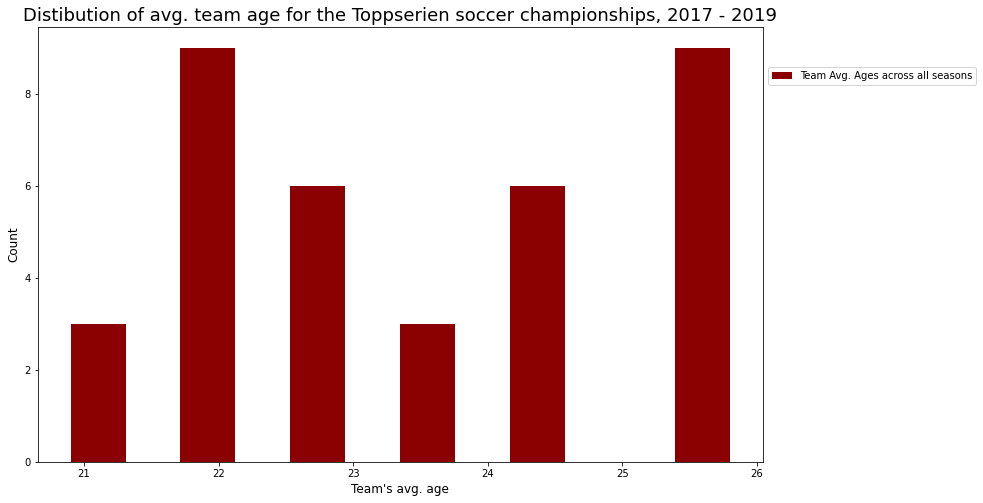

In [32]:
# Visualizing the distribution of avg. ages
teams_avg_age_2017 = teams_2017_df[('Unnamed: 2_level_0', 'Age')]
teams_avg_age_2018 = teams_2017_df[('Unnamed: 2_level_0', 'Age')]
teams_avg_age_2019 = teams_2017_df[('Unnamed: 2_level_0', 'Age')]
teams_avg_ages_all_seasons = teams_avg_age_2017.append([teams_avg_age_2018, teams_avg_age_2019]).values
    
fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(teams_avg_ages_all_seasons, label='Team Avg. Ages across all seasons',
                            stacked=False, color='darkred', bins=12)
# Set labels for histogram
ax1.set_ylabel('Count', size=12)
ax1.set_xlabel("Team's avg. age", size=12)
ax1.set_title('Distibution of avg. team age for the Toppserien soccer championships, 2017 - 2019', size=18)
ax1.legend(bbox_to_anchor=(1, 0.92))

fig.set_figheight(8)
fig.set_figwidth(13)

plt.show()

### <a id="top-tier-team"></a>3.9) Adding a feature to distinguish top-tier teams

Finally, I want to add a dummy variable that indicates whether the teams finished in the top 5 last season or not. 
This should work as an additional indicator that hopefully helps the model understand that some teams are "star teams" and perform a lot better than the rest. We can for example see from the distribution of scores that *LSK Kvinner* and *Vålerenga* have been dominating Toppserien for the last three years. Later I will experiment more with this metric, in order to find the optimum value for n for the "top n" teams that dominate the championships. 

In [33]:
# Loading the championship dataset
table_2017_df = pd.read_html("Raw Data/2017/table.xls", encoding="UTF-8")[0]
table_2018_df = pd.read_html("Raw Data/2018/table.xls", encoding="UTF-8")[0]
table_2019_df = pd.read_html("Raw Data/2019/table.xls", encoding="UTF-8")[0]
table_2019_df

,Rk,Squad,MP,W,D,L,GF,GA,GD,Pts,Attendance,Top Team Scorer,Goalkeeper,Notes
0,1,LSK Kvinner,22,15,5,2,51,18,33,50,339,"Guro Reiten, Elise Thorsnes - 12",Cecilie Fiskerstrand,→ Champions League via league finish
1,2,Vålerenga,22,14,4,4,41,24,17,46,489,"Natasha Dowie, Ajara Nchout - 11",Hannah Seabert,→ Champions League via league finish
2,3,Klepp,22,14,2,6,48,19,29,44,260,"Havana Solaun, Tameka Butt - 10",Lindsey Harris,NaN
3,4,Sandviken,22,12,4,6,43,32,11,40,465,Kennya Cordner - 17,Nora Neset Gjøen,NaN
4,5,Avaldsnes,22,9,7,6,40,33,7,34,172,Giovanna - 9,Victoria Esson,NaN
5,6,Røa,22,7,8,7,40,35,5,29,305,Synne Jensen - 16,Kirvil Schau Odden,NaN
6,7,Trondheims-Ørn,22,8,5,9,26,22,4,29,264,Marit Clausen - 9,Kristine Nøstmo,NaN
7,8,Kolbotn,22,7,6,9,35,39,-4,27,167,Isabell Herlovsen - 8,Aurora Mikalsen,NaN
8,9,Arna-Bjørnar,22,6,5,11,26,41,-15,23,295,Milica Mijatović - 7,Oda Bogstad,NaN
9,10,Lyn,22,4,8,10,23,37,-14,20,191,Runa Lillegård - 10,Karen Oline Sneve,→ Norwegian 1/2 Relegation/Promotion Playoff (W)


In [34]:
# Removing features irrelevant for exploration and prediction
for df in [table_2017_df, table_2018_df, table_2019_df]:
    df.drop(labels="Notes", inplace=True, axis=1)

In [35]:
# Adding two new features indicating whether the teams
# finished in the top 5 last season. 

# .loc isn't working properly here for some reason, so I am using a list to store the values 
# for the new feature.
top_5_team = []
top_5_opponent = []

# Looping over the games data and inserting the value for the Top5Team dummy indicators as I go
for index, row in games_df.iterrows():
    team = row["Team"]
    opponent = row["Opponent"]
    current_season = row["Season"]
    
    # For 2017 values are set to 0 (no one finished in the top 5)
    if current_season == 2017:
        top_5_team.append(0)
        top_5_opponent.append(0)
        
    
    # For the other seasons I check what the team's placement for last year's season was
    if current_season == 2018:
        team_placement = table_2017_df.loc[(table_2017_df["Squad"] == team), "Rk"]
        opponent_placement = table_2017_df.loc[(table_2017_df["Squad"] == opponent), "Rk"]
        # Calculating whether the team is a top 5 team
        try:
            if int(team_placement) < 6:
                top_5_team.append(1)
            else:
                top_5_team.append(0)

        except TypeError as err:
            # TypeError occurs when the team can't be found in the table
            # Which means they were recently promoted from 1st division
            top_5_team.append(0)
        
        # Calculating whether the opponent is a top 5 opponent
        try:
            if int(opponent_placement) < 6:
                top_5_opponent.append(1)
            else:
                top_5_opponent.append(0)
        
        except TypeError as err:
            # TypeError occurs when the opponent can't be found in the table
            # Which means they were recently promoted from 1st division
            top_5_opponent.append(0)
        
                      
    if current_season == 2019:
        team_placement = table_2018_df.loc[(table_2018_df["Squad"] == team), "Rk"]
        opponent_placement = table_2018_df.loc[(table_2018_df["Squad"] == opponent), "Rk"]
        
        # Calculating whether the team is a top 5 team
        try:
            if int(team_placement) < 6:
                top_5_team.append(1)
            else:
                top_5_team.append(0)
        
        except TypeError as err:
            # TypeError occurs when the team can't be found in the table
            # Which means they were recently promoted from 1st division
            top_5_team.append(0)
            
        # Calculating whether the opponent is a top 5 opponent
        try:
            if int(opponent_placement) < 6:
                top_5_opponent.append(1)
            else:
                top_5_opponent.append(0)
        
        except TypeError as err:
            # TypeError occurs when the opponent can't be found in the table
            # Which means they were recently promoted from 1st division
            top_5_opponent.append(0)
            
    
    if current_season == 2020:
        team_placement = table_2019_df.loc[(table_2019_df["Squad"] == team), "Rk"]
        opponent_placement = table_2019_df.loc[(table_2019_df["Squad"] == opponent), "Rk"]
        
        # Calculating whether the team is a top 5 team
        try:
            if int(team_placement) < 6:
                top_5_team.append(1)
            else:
                top_5_team.append(0)
        
        except TypeError as err:
            # TypeError occurs when the team can't be found in the table
            # Which means they were recently promoted from 1st division
            top_5_team.append(0)
            
        # Calculating whether the opponent is a top 5 opponent
        try:
            if int(opponent_placement) < 6:
                top_5_opponent.append(1)
            else:
                top_5_opponent.append(0)
        
        except TypeError as err:
            # TypeError occurs when the opponent can't be found in the table
            # Which means they were recently promoted from 1st division
            top_5_opponent.append(0)


# Creating the two new features with the calculated values
games_df["Top 5 Team"] = top_5_team
games_df["Top 5 Opponent"] = top_5_opponent

# Reordering the features again so that the predictor variables appear at the end
games_df = games_df[[col for col in games_df.columns if col not in ["y1: Team Score", "y2: Opponent Score"]] + ["y1: Team Score", "y2: Opponent Score"]]

# View the result
display(games_df.head())
display(games_df.tail())

,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent,y1: Team Score,y2: Opponent Score
0,2017,Medkila,Sandviken,Home,1.0,-0.166667,2017-04-17,1.640152,1.640152,21.9,25.0,0,0,1.0,1.0
1,2017,Arna-Bjørnar,Grand Bodø,Away,1.0,-0.166667,2017-04-17,1.640152,1.640152,22.9,25.2,0,0,2.0,2.0
2,2017,Stabæk,Røa,Away,2.0,-1.833333,2017-04-17,1.640152,1.640152,21.9,22.4,0,0,2.0,1.0
3,2017,Klepp,LSK Kvinner,Away,1.0,1.250000,2017-04-17,1.640152,1.640152,25.2,20.1,0,0,1.0,6.0
4,2017,Kolbotn,Trondheims-Ørn,Away,1.0,1.166667,2017-04-17,1.640152,1.640152,22.4,21.8,0,0,2.0,3.0


,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent,y1: Team Score,y2: Opponent Score
179,2020,Arna-Bjørnar,Sandviken,Away,17.0,-0.571429,2020-09-27,1.18,1.95,22.4,25.3,0,1,NaN,NaN
180,2020,Røa,LSK Kvinner,Home,18.0,-2.000000,2020-07-17,1.77,2.27,22.9,25.3,0,1,NaN,NaN
181,2020,Kolbotn,LSK Kvinner,Home,20.0,-1.714286,2020-11-07,1.59,2.27,21.8,25.3,0,1,NaN,NaN
182,2020,Arna-Bjørnar,Røa,Away,18.0,-0.571429,2020-07-04,1.18,1.77,22.4,22.9,0,0,NaN,NaN
183,2020,Sandviken,Lyn,Away,18.0,1.800000,2020-09-12,1.95,1.05,25.3,20.1,1,0,NaN,NaN


In [36]:
# Separating the 2020 data from the games dataset
# because I don't want to calculate descriptive statistics for it
games_2020_df = games_df.loc[games_df["Season"] == 2020].drop(columns=["y1: Team Score", "y2: Opponent Score"])
games_df = games_df.loc[games_df["Season"] != 2020]
display(games_2020_df.head())
games_df.tail()

,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent
0,2020,Trondheims-Ørn,Klepp,Home,1.0,-0.166667,2020-08-02,1.18,2.18,21.9,25.0,0,1
1,2020,Røa,Vålerenga,Away,1.0,-0.166667,2020-07-10,1.77,1.86,22.9,25.2,0,1
2,2020,Trondheims-Ørn,Arna-Bjørnar,Home,2.0,-1.833333,2020-08-30,1.18,1.18,21.9,22.4,0,0
3,2020,Vålerenga,Lyn,Home,1.0,1.250000,2020-08-26,1.86,1.05,25.2,20.1,1,0
4,2020,Arna-Bjørnar,Kolbotn,Home,1.0,1.166667,2020-09-12,1.18,1.59,22.4,21.8,0,0


,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent,y1: Team Score,y2: Opponent Score
791,2019,Avaldsnes,Trondheims-Ørn,Home,22.0,1.0,2019-11-16,1.090000,1.140000,24.400000,21.900000,0,0,0.0,1.0
792,2019,Lyn,IF Fløya,Away,23.0,0.0,2019-11-24,1.180000,0.925741,20.100000,23.408333,0,0,5.0,0.0
793,2019,IF Fløya,Lyn,Home,1.0,0.0,2019-11-24,0.925741,1.180000,23.408333,20.100000,0,0,0.0,5.0
794,2019,Lyn,IF Fløya,Home,24.0,5.0,2019-12-01,1.180000,0.925741,20.100000,23.408333,0,0,2.0,1.0
795,2019,IF Fløya,Lyn,Away,2.0,-5.0,2019-12-01,0.925741,1.180000,23.408333,20.100000,0,0,1.0,2.0


In [37]:
games_df.describe()

,Season,Game # in season,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent,y1: Team Score,y2: Opponent Score
count,796.000000,796.000000,7.960000e+02,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000
mean,2018.005025,11.815327,2.231604e-18,1.638645,1.638645,23.373696,23.373696,0.276382,0.276382,1.616834,1.616834
std,0.818020,6.396525,1.665302e+00,0.488728,0.488728,1.756381,1.756381,0.447489,0.447489,1.515594,1.515594
min,2017.000000,1.000000,-7.000000e+00,0.730000,0.730000,19.800000,19.800000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,6.000000,-1.000000e+00,1.360000,1.360000,21.900000,21.900000,0.000000,0.000000,0.000000,0.000000
50%,2018.000000,12.000000,0.000000e+00,1.640152,1.640152,23.404167,23.404167,0.000000,0.000000,1.000000,1.000000
75%,2019.000000,17.000000,1.000000e+00,1.730000,1.730000,25.100000,25.100000,1.000000,1.000000,2.000000,2.000000
max,2019.000000,24.000000,7.000000e+00,3.090000,3.090000,26.400000,26.400000,1.000000,1.000000,9.000000,9.000000


### <a id=ohe></a>3.10) One Hot Encoding categorical features

In [38]:
# Re-joining the games data
games_df = pd.concat([games_df, games_2020_df], axis=0)
display(games_df.tail())

# One Hot Encoding of categorical variables
games_df = pd.get_dummies(games_df)
print(f"                   FEATURE                     DTYPE")
print("------------------------------------------|--------------|")
print(games_df.dtypes)

,Season,Team,Opponent,Venue,Game # in season,Avg. Historical Score Diff,Date,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent,y1: Team Score,y2: Opponent Score
179,2020,Arna-Bjørnar,Sandviken,Away,17.0,-0.571429,2020-09-27,1.18,1.95,22.4,25.3,0,1,NaN,NaN
180,2020,Røa,LSK Kvinner,Home,18.0,-2.000000,2020-07-17,1.77,2.27,22.9,25.3,0,1,NaN,NaN
181,2020,Kolbotn,LSK Kvinner,Home,20.0,-1.714286,2020-11-07,1.59,2.27,21.8,25.3,0,1,NaN,NaN
182,2020,Arna-Bjørnar,Røa,Away,18.0,-0.571429,2020-07-04,1.18,1.77,22.4,22.9,0,0,NaN,NaN
183,2020,Sandviken,Lyn,Away,18.0,1.800000,2020-09-12,1.95,1.05,25.3,20.1,1,0,NaN,NaN


                   FEATURE                     DTYPE
------------------------------------------|--------------|
Season                                              int64
Game # in season                                  float64
Avg. Historical Score Diff                        float64
Date                                       datetime64[ns]
Team's goals per 90 min last season               float64
Opponent's goals per 90 min last season           float64
Team's Avg. Age                                   float64
Opponent's Avg. Age                               float64
Top 5 Team                                          int64
Top 5 Opponent                                      int64
y1: Team Score                                    float64
y2: Opponent Score                                float64
Team_Arna-Bjørnar                                   uint8
Team_Avaldsnes                                      uint8
Team_Fart                                           uint8
Team_Grand Bodø   

In [39]:
# Reordering columns
games_df = games_df[["Date", "Season", 'Team_Arna-Bjørnar', 'Team_Avaldsnes',
       'Team_Fart', 'Team_Grand Bodø', 'Team_IF Fløya', 'Team_Klepp',
       'Team_Kolbotn', 'Team_LSK Kvinner', 'Team_Lyn', 'Team_Medkila',
       'Team_Røa', 'Team_Sandviken', 'Team_Stabæk', 'Team_Trondheims-Ørn',
       'Team_Vålerenga', 'Opponent_Arna-Bjørnar', 'Opponent_Avaldsnes',
       'Opponent_Fart', 'Opponent_Grand Bodø', 'Opponent_IF Fløya',
       'Opponent_Klepp', 'Opponent_Kolbotn', 'Opponent_LSK Kvinner',
       'Opponent_Lyn', 'Opponent_Medkila', 'Opponent_Røa',
       'Opponent_Sandviken', 'Opponent_Stabæk', 'Opponent_Trondheims-Ørn',
       'Opponent_Vålerenga', 'Venue_Away', 'Venue_Home', "Game # in season",
       "Avg. Historical Score Diff", 
       "Team's goals per 90 min last season",
       "Opponent's goals per 90 min last season", "Team's Avg. Age",
       "Opponent's Avg. Age", "Top 5 Team", "Top 5 Opponent", "y1: Team Score",
       "y2: Opponent Score"]]

In [40]:
# Separating the 2020 data, again
games_2020_df = games_df.loc[games_df["Season"] == 2020].drop(columns=["y1: Team Score", "y2: Opponent Score", 
                                                                       "Date"])
games_df = games_df.loc[games_df["Season"] != 2020]
games_df.tail()

# Reattach game IDs to the 2020 game data
games_2020_df = pd.concat([game_ids, games_2020_df], axis=1)
display(games_2020_df.tail())

,ID,Season,Team_Arna-Bjørnar,Team_Avaldsnes,Team_Fart,Team_Grand Bodø,Team_IF Fløya,Team_Klepp,Team_Kolbotn,Team_LSK Kvinner,Team_Lyn,Team_Medkila,Team_Røa,Team_Sandviken,Team_Stabæk,Team_Trondheims-Ørn,Team_Vålerenga,Opponent_Arna-Bjørnar,Opponent_Avaldsnes,Opponent_Fart,Opponent_Grand Bodø,Opponent_IF Fløya,Opponent_Klepp,Opponent_Kolbotn,Opponent_LSK Kvinner,Opponent_Lyn,Opponent_Medkila,Opponent_Røa,Opponent_Sandviken,Opponent_Stabæk,Opponent_Trondheims-Ørn,Opponent_Vålerenga,Venue_Away,Venue_Home,Game # in season,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent
179,179,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,17.0,-0.571429,1.18,1.95,22.4,25.3,0,1
180,180,2020,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,18.0,-2.000000,1.77,2.27,22.9,25.3,0,1
181,181,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,20.0,-1.714286,1.59,2.27,21.8,25.3,0,1
182,182,2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,18.0,-0.571429,1.18,1.77,22.4,22.9,0,0
183,183,2020,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,18.0,1.800000,1.95,1.05,25.3,20.1,1,0


[*back to top*](#top)
## <a id="saving"></a>4) Saving the cleaned data

In [41]:
print("Cleaned data looks like this:")
display(games_df.head())

# Saving the cleaned data as .csv
games_df.to_csv("Prepared Data/games_prepared.csv", index=False, encoding="UTF-8")  # for training and evaluating ML models
games_2020_df.to_csv("Prepared Data/games_2020_prepared.csv", index=False, encoding="UTF-8")  # for predicting on 2020 data
teams_2019_df.to_csv("Prepared Data/2019_team-stats_prepared.csv")  # for preprocessing website input
table_2019_df.to_csv("Prepared Data/2019_table_prepared.csv", index=False)

# Saving the cleaned data as .html
games_df.to_html("Prepared Data/games_prepared.html", index=False, encoding="UTF-8")
games_2020_df.to_html("Prepared Data/games_2020_prepared.html", index=False, encoding="UTF-8")

Cleaned data looks like this:


,Date,Season,Team_Arna-Bjørnar,Team_Avaldsnes,Team_Fart,Team_Grand Bodø,Team_IF Fløya,Team_Klepp,Team_Kolbotn,Team_LSK Kvinner,Team_Lyn,Team_Medkila,Team_Røa,Team_Sandviken,Team_Stabæk,Team_Trondheims-Ørn,Team_Vålerenga,Opponent_Arna-Bjørnar,Opponent_Avaldsnes,Opponent_Fart,Opponent_Grand Bodø,Opponent_IF Fløya,Opponent_Klepp,Opponent_Kolbotn,Opponent_LSK Kvinner,Opponent_Lyn,Opponent_Medkila,Opponent_Røa,Opponent_Sandviken,Opponent_Stabæk,Opponent_Trondheims-Ørn,Opponent_Vålerenga,Venue_Away,Venue_Home,Game # in season,Avg. Historical Score Diff,Team's goals per 90 min last season,Opponent's goals per 90 min last season,Team's Avg. Age,Opponent's Avg. Age,Top 5 Team,Top 5 Opponent,y1: Team Score,y2: Opponent Score
0,2017-04-17,2017,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1.0,-0.166667,1.640152,1.640152,21.9,25.0,0,0,1.0,1.0
1,2017-04-17,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1.0,-0.166667,1.640152,1.640152,22.9,25.2,0,0,2.0,2.0
2,2017-04-17,2017,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2.0,-1.833333,1.640152,1.640152,21.9,22.4,0,0,2.0,1.0
3,2017-04-17,2017,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.0,1.250000,1.640152,1.640152,25.2,20.1,0,0,1.0,6.0
4,2017-04-17,2017,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1.0,1.166667,1.640152,1.640152,22.4,21.8,0,0,2.0,3.0
